# Training with SVM

In this case, I chose a **SVM** model, which is already implemented in the library Scikit-Learn.

In [1]:
import copy
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [2]:
def get_categories(df):
    return df['category'].unique()

## Prepare dataset

You can notice that it is very simple to configure a SVM model as many functions are already implemented. Basically, I only needed to transform the categories into numbers

In [3]:
df = pd.read_csv('../data/parsed/tfidf_dataset.csv')
df.head()

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment


In [4]:
X_data = df[['text']].to_numpy().reshape(-1)
Y_data = df[['category']].to_numpy().reshape(-1)

In [5]:
"""category_to_id = {}
category_to_name = {}

for index, c in enumerate(Y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    Y_data[index] = category_id

Y_data = Y_data.astype(np.int32)

# Display dictionary
category_to_name"""

'category_to_id = {}\ncategory_to_name = {}\n\nfor index, c in enumerate(Y_data):\n    if c in category_to_id:\n        category_id = category_to_id[c]\n    else:\n        category_id = len(category_to_id)\n        category_to_id[c] = category_id\n        category_to_name[category_id] = c\n    \n    Y_data[index] = category_id\n\nY_data = Y_data.astype(np.int32)\n\n# Display dictionary\ncategory_to_name'

In [6]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

n_categories = len(get_categories(df))
print('Number of categories: %d' % n_categories)

print('Loading train dataset...')
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3)

print('Done!')

Texts in dataset: 2225
Number of categories: 5
Loading train dataset...
Done!


## Create SVM model

Use `GridSearch` to find the best parameters.

In [7]:
model_params = {
    'svm__loss': ['hinge', 'modified_huber', 'log', 'squared_loss'],
    'svm__penalty': ['l1', 'l2'],
    'svm__alpha': [1e-3, 1e-4, 1e-5],
    'svm__tol': [1e-3, 1e-4],
    'svm__random_state': [42]
}

svm_model = Pipeline([('vect', CountVectorizer(strip_accents=None, lowercase=False)),
                      ('svm', SGDClassifier())])

# 10-fold cross validation
clf = model_selection.GridSearchCV(svm_model,
                                   model_params,
                                   cv=10,
                                   verbose=3)
clf.fit(X_train, Y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.936, total=   2.4s
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.981, total=   1.3s
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.949, total=   1.4s
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.936, total=   0.9s
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.962, total=   1.0s
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.891, total=   0.9s
[CV] svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.904, total=   0.9s
[CV] 

[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.949, total=   0.9s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.981, total=   0.7s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.962, total=   0.9s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.917, total=   1.4s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__p

[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.942, total=   0.6s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.917, total=   0.7s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.961, total=   0.6s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.948, total=   0.7s
[CV] svm__alpha=0.001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=modified_huber

[CV]  svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.942, total=   0.7s
[CV] svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.974, total=   0.7s
[CV] svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.942, total=   0.7s
[CV] svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.949, total=   0.8s
[CV] svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.961, total=   0.7s
[CV] svm__alph

/Users/dimasdmm/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.250, total=   7.4s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.244, total=   8.0s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.186, total=   7.3s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.147, total=  14.9s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l1, svm__ra

[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.205, total=   1.0s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.200, total=   1.0s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.232, total=   0.9s
[CV] svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.194, total=   1.2s
[CV] svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l1, svm__random_

[CV]  svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.936, total=   0.6s
[CV] svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.974, total=   0.6s
[CV] svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.936, total=   0.7s
[CV] svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.949, total=   0.6s
[CV] svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.961, t

[CV]  svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.961, total=   2.4s
[CV] svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.955, total=   3.5s
[CV] svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.962, total=   2.9s
[CV] svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001, score=0.981, total=   2.3s
[CV] svm__alpha=0.0001, svm__loss=modified_huber, svm__penalty=l2, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=0.0001, svm__loss=modified

[CV]  svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.929, total=   1.2s
[CV] svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.929, total=   2.4s
[CV] svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.955, total=   1.6s
[CV] svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.948, total=   1.9s
[CV] svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=log, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.968, total=   0.6s
[CV] svm__alph

[CV]  svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.218, total=   1.0s
[CV] svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.224, total=   1.3s
[CV] svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.308, total=   1.0s
[CV] svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.224, total=   1.2s
[CV] svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=0.0001, svm__loss=squared_loss, svm__penalty=l2

[CV]  svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.948, total=   1.3s
[CV] svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.961, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.968, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.981, total=   1.1s
[CV] svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.001 
[CV]  svm__alpha=1e-05, svm__loss=hinge, svm__penalty=l2, svm__random_state=42, svm__tol=0.001, score=0.974, total=   1.9s
[C

[CV]  svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.929, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.936, total=   1.7s
[CV] svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.961, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.961, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=modified_huber, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=modified_huber

[CV]  svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.981, total=   0.9s
[CV] svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.968, total=   0.9s
[CV] svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.936, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.974, total=   0.8s
[CV] svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=log, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.936, total=   1.2s
[CV] svm__alph

[CV]  svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.001, score=0.148, total=   1.7s
[CV] svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.135, total=   1.7s
[CV] svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.237, total=   2.1s
[CV] svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001, score=0.147, total=   1.6s
[CV] svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, svm__random_state=42, svm__tol=0.0001 
[CV]  svm__alpha=1e-05, svm__loss=squared_loss, svm__penalty=l1, 

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 13.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pr

In [8]:
print('Best parameters set:')
print(clf.best_params_)

Best parameters set:
{'svm__alpha': 0.001, 'svm__loss': 'log', 'svm__penalty': 'l2', 'svm__random_state': 42, 'svm__tol': 0.001}


## Evaluation

It took very few time to train the model and the results are pretty good. This approach got a global accuracy of $96.71\%$, which is slightly more than the LSTM model and, in comparison to that model, SVM is much faster to train.

In [9]:
def plot_confusion_matrix(X_test, Y_test, model):
    Y_pred = model.predict(X_test)

    con_mat = confusion_matrix(Y_test, Y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    label_names = list(range(len(con_mat_norm)))
    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
Y_pred = clf.predict(X_test)

In [11]:
print('Accuracy: %.4f' % accuracy_score(Y_pred, Y_test))

print('Classification report:')
print(classification_report(Y_test, Y_pred))

Accuracy: 0.9671
Classification report:
               precision    recall  f1-score   support

     business       0.95      0.96      0.96       136
entertainment       0.98      0.95      0.97       124
     politics       0.94      0.97      0.96       118
        sport       0.98      1.00      0.99       162
         tech       0.98      0.94      0.96       128

     accuracy                           0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668



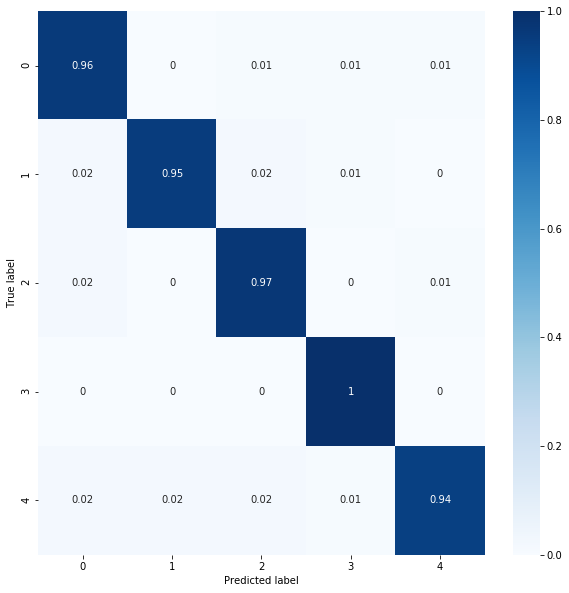

In [12]:
plot_confusion_matrix(X_test, Y_test, clf)

## Save the model

In [13]:
def create_artifacts_dir():
    try:
        os.mkdir('../artifacts')
    except:
        pass

In [14]:
def save_model(model):
    with open('../artifacts/svm.pickle', 'wb') as fp:
        pickle.dump(model, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
create_artifacts_dir()
save_model(clf)